In [1]:
import sys
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from IPython.display import Image
from scipy import optimize

from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5

geom  = SheetGeometry
model = PlanarModel

C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


In [2]:
import warnings
warnings.filterwarnings('ignore')

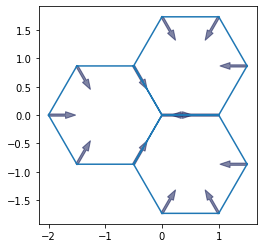

In [3]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet, extra_cols={"edge":["dx", "dy"]})

sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

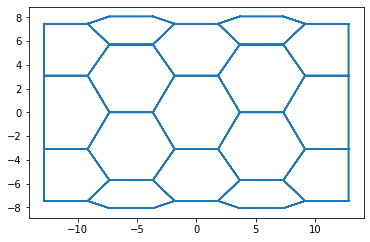

In [4]:
h5store = 'data/small_hexagonal.hf5'
#h5store = 'data/before_apoptosis.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
sheet.sanitize(trim_borders=True, order_edges=True)

geom.update_all(sheet)


fig, ax = sheet_view(sheet, ['z', 'x'], mode='quick')

In [5]:
model_specs = {
    "edge": {
        "line_tension": 1.,
    },
    "face": {
        "contractility": 1.,
        "vol_elasticity": 1.,
        "prefered_vol": sheet.face_df["vol"].mean(),
    },
}

sheet.update_specs(model_specs, reset=True)

Reseting column line_tension of the edge dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs


In [6]:
model = model_factory([
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity
])

In [7]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

UndefinedVariableError: name 'area_elasticity' is not defined

In [ ]:
grad_E = model.compute_gradient(sheet)

grad_E.head()

In [ ]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

In [ ]:
fig, ax = plot_forces(sheet, geom, model, ['z', 'y'], scaling=0.1)
fig.set_size_inches(10, 12)

In [ ]:
solver = QSSolver()

scale = 0.2
fig, ax = plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})

def draw_approx_force(ax=None):
    fig, ax = plot_forces(sheet, geom, model,
                          ['z', 'x'], scaling=scale, ax=ax,
                          approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

In [ ]:
grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))

In [ ]:
options ={'disp':False,
          'ftol':1e-5,
          'gtol':1e-5}


res = solver.find_energy_min(sheet, geom, model, options=options)
print(res['success'])

In [ ]:
fig, ax = plot_forces(sheet, geom, model, ['z', 'y'], 1)
fig.set_size_inches(10, 12)

In [ ]:
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True)


In [ ]:
def on_topo_change(sheet):
    print("reseting tension")
    sheet.edge_df["line_tension"] = sheet.specs["edge"]["line_tension"]


In [ ]:
res = solver.solve(tf=8, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver.eptm,))

In [ ]:
create_gif(solver.history, "sheet3.gif")